[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Munyi-James173/Data-Science/blob/main/Data%20Oracles.ipynb)

In [2]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# data_path = "C:/Users/User/Desktop/Capstone"
# files = os.listdir(data_path)
# print(files)

In [ ]:
# Reading the file datasets file from github

pesticides_df = r'https://github.com/Munyi-James173/Data-Science/blob/main/pesticides.csv'
rainfall_df = r'https://github.com/Munyi-James173/Data-Science/blob/main/rainfall.csv'
temp_df = r'https://github.com/Munyi-James173/Data-Science/blob/main/temp.csv'
yield_df = r'https://github.com/Munyi-James173/Data-Science/blob/main/yield.csv'
yield_df_df =r'https://github.com/Munyi-James173/Data-Science/blob/main/yield_df.csv'

In [7]:
# Convert GitHub file page URLs to raw URLs and read CSVs robustly
def to_raw_github(url: str) -> str:
    if isinstance(url, str) and "github.com" in url:
        return url.replace("github.com", "raw.githubusercontent.com").replace("/blob/", "/")
    return url

csv_vars = {
    "pesticides_df": pesticides_df,
    "rainfall_df": rainfall_df,
    "temp_df": temp_df,
    "yield_df": yield_df,
    "yield_df_df": yield_df_df,
}

for var_name, url in csv_vars.items():
    raw_url = to_raw_github(url)
    try:
        df = pd.read_csv(raw_url)
    except Exception:
        # fallback: be more tolerant to malformed rows
        df = pd.read_csv(raw_url, engine="python", on_bad_lines="skip")
    globals()[var_name] = df
    print(f"{var_name}: {globals()[var_name].shape}")

pesticides_df: (4349, 7)
rainfall_df: (6727, 3)
temp_df: (71311, 3)
yield_df: (56717, 12)
yield_df_df: (28242, 8)


In [8]:
#To inspect columns
print(pesticides_df.columns)
print(rainfall_df.columns)
print(temp_df.columns)
print(yield_df.columns)

Index(['Domain', 'Area', 'Element', 'Item', 'Year', 'Unit', 'Value'], dtype='object')
Index([' Area', 'Year', 'average_rain_fall_mm_per_year'], dtype='object')
Index(['year', 'country', 'avg_temp'], dtype='object')
Index(['Domain Code', 'Domain', 'Area Code', 'Area', 'Element Code', 'Element',
       'Item Code', 'Item', 'Year Code', 'Year', 'Unit', 'Value'],
      dtype='object')


In [11]:
temp_df.head()

,year,country,avg_temp
0,1849,Côte D'Ivoire,25.58
1,1850,Côte D'Ivoire,25.52
2,1851,Côte D'Ivoire,25.67
3,1852,Côte D'Ivoire,NaN
4,1853,Côte D'Ivoire,NaN


In [12]:
temp_df['country'].value_counts()

country
United States       11973
China                6172
India                4756
Russia               2257
Brazil               1997
                    ...  
Mozambique            157
Lesotho               157
Eritrea               150
Peru                  133
Papua New Guinea      132
Name: count, Length: 137, dtype: int64

In [13]:
rainfall_df.head()

,Area,Year,average_rain_fall_mm_per_year
0,Afghanistan,1985,327
1,Afghanistan,1986,327
2,Afghanistan,1987,327
3,Afghanistan,1989,327
4,Afghanistan,1990,327


In [14]:
#renaming the column country to area
temp_df.rename(columns={"country": "area"}, inplace=True)

In [15]:
#Common keys are: 'Area' and 'Year'
#Creating a master dataset

for df in [rainfall_df, temp_df, pesticides_df, yield_df]:
    df.columns = df.columns.str.strip().str.lower()

master_df = (
    rainfall_df
    .merge(temp_df, on=["area", "year"], how="inner")
    .merge(pesticides_df, on=["area", "year"], how="inner")
    .merge(yield_df, on=["area", "year"], how="inner")
)

print("Master shape:", master_df.shape)
print("Columns after master:", master_df.columns)

Master shape: (28248, 19)
Columns after master: Index(['area', 'year', 'average_rain_fall_mm_per_year', 'avg_temp', 'domain_x',
       'element_x', 'item_x', 'unit_x', 'value_x', 'domain code', 'domain_y',
       'area code', 'element code', 'element_y', 'item code', 'item_y',
       'year code', 'unit_y', 'value_y'],
      dtype='object')


In [16]:
#Inspecting master_df

master_df.head()

,area,year,average_rain_fall_mm_per_year,avg_temp,domain_x,element_x,item_x,unit_x,value_x,domain code,domain_y,area code,element code,element_y,item code,item_y,year code,unit_y,value_y
0,Albania,1990,1485,16.37,Pesticides Use,Use,Pesticides (total),tonnes of active ingredients,121.0,QC,Crops,3,5419,Yield,56,Maize,1990,hg/ha,36613
1,Albania,1990,1485,16.37,Pesticides Use,Use,Pesticides (total),tonnes of active ingredients,121.0,QC,Crops,3,5419,Yield,116,Potatoes,1990,hg/ha,66667
2,Albania,1990,1485,16.37,Pesticides Use,Use,Pesticides (total),tonnes of active ingredients,121.0,QC,Crops,3,5419,Yield,27,"Rice, paddy",1990,hg/ha,23333
3,Albania,1990,1485,16.37,Pesticides Use,Use,Pesticides (total),tonnes of active ingredients,121.0,QC,Crops,3,5419,Yield,83,Sorghum,1990,hg/ha,12500
4,Albania,1990,1485,16.37,Pesticides Use,Use,Pesticides (total),tonnes of active ingredients,121.0,QC,Crops,3,5419,Yield,236,Soybeans,1990,hg/ha,7000


In [17]:
master_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28248 entries, 0 to 28247
Data columns (total 19 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   area                           28248 non-null  object 
 1   year                           28248 non-null  int64  
 2   average_rain_fall_mm_per_year  28248 non-null  object 
 3   avg_temp                       28248 non-null  float64
 4   domain_x                       28248 non-null  object 
 5   element_x                      28248 non-null  object 
 6   item_x                         28248 non-null  object 
 7   unit_x                         28248 non-null  object 
 8   value_x                        28248 non-null  float64
 9   domain code                    28248 non-null  object 
 10  domain_y                       28248 non-null  object 
 11  area code                      28248 non-null  int64  
 12  element code                   28248 non-null 

In [18]:
#Identifying missing values

print(master_df.isnull().sum())
missing = master_df.isnull().sum()
missing[missing > 0]

area                             0
year                             0
average_rain_fall_mm_per_year    0
avg_temp                         0
domain_x                         0
element_x                        0
item_x                           0
unit_x                           0
value_x                          0
domain code                      0
domain_y                         0
area code                        0
element code                     0
element_y                        0
item code                        0
item_y                           0
year code                        0
unit_y                           0
value_y                          0
dtype: int64


Series([], dtype: int64)

In [19]:
#Check for duplicates

print(master_df.duplicated().sum())

2310


In [20]:
master_df.describe()

,year,avg_temp,value_x,area code,element code,item code,year code,value_y
count,28248.000000,28248.000000,28248.000000,28248.000000,28248.0,28248.000000,28248.000000,28248.000000
mean,2001.541950,20.543722,37069.136973,107.259594,5419.0,102.156684,2001.541950,77047.863282
std,7.052997,6.311828,59954.787836,64.992914,0.0,84.842899,7.052997,84950.194454
min,1990.000000,1.300000,0.040000,1.000000,5419.0,15.000000,1990.000000,50.000000
25%,1995.000000,16.710000,1695.710000,56.000000,5419.0,27.000000,1995.000000,19918.750000
50%,2001.000000,21.510000,17517.760000,100.000000,5419.0,83.000000,2001.000000,38295.000000
75%,2008.000000,26.000000,48687.880000,157.000000,5419.0,122.000000,2008.000000,104598.250000
max,2013.000000,30.650000,367778.000000,276.000000,5419.0,489.000000,2013.000000,501412.000000


In [14]:
#Updated dataset

master_df.to_csv("C:/Users/User/Desktop/Capstone/master_df.csv", index=False)

In [21]:
#check the elements in each column
master_df['element code'].value_counts()

element code
5419    28248
Name: count, dtype: int64

In [22]:
master_df.rename(columns={'value_x':'pesticide_tonnes','value_y':'yield_hg/ha'},inplace=True)

In [23]:
master_df.drop(
    columns=['domain_x', 'element_x', 'item_x', 'unit_x', 'element code', 
             'domain_y', 'element_y', 'unit_y', 'domain code','year code'], 
    inplace=True
)

In [24]:
master_df.head()

,area,year,average_rain_fall_mm_per_year,avg_temp,pesticide_tonnes,area code,item code,item_y,yield_hg/ha
0,Albania,1990,1485,16.37,121.0,3,56,Maize,36613
1,Albania,1990,1485,16.37,121.0,3,116,Potatoes,66667
2,Albania,1990,1485,16.37,121.0,3,27,"Rice, paddy",23333
3,Albania,1990,1485,16.37,121.0,3,83,Sorghum,12500
4,Albania,1990,1485,16.37,121.0,3,236,Soybeans,7000


# Exploratory Data Analysis

In [25]:
#To get a sense of how many rows and columns we have in the master table, and what types of data (numeric, categorical, etc.).
master_df.shape
master_df.info()
master_df.head()
master_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28248 entries, 0 to 28247
Data columns (total 9 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   area                           28248 non-null  object 
 1   year                           28248 non-null  int64  
 2   average_rain_fall_mm_per_year  28248 non-null  object 
 3   avg_temp                       28248 non-null  float64
 4   pesticide_tonnes               28248 non-null  float64
 5   area code                      28248 non-null  int64  
 6   item code                      28248 non-null  int64  
 7   item_y                         28248 non-null  object 
 8   yield_hg/ha                    28248 non-null  int64  
dtypes: float64(2), int64(4), object(3)
memory usage: 1.9+ MB


,year,avg_temp,pesticide_tonnes,area code,item code,yield_hg/ha
count,28248.000000,28248.000000,28248.000000,28248.000000,28248.000000,28248.000000
mean,2001.541950,20.543722,37069.136973,107.259594,102.156684,77047.863282
std,7.052997,6.311828,59954.787836,64.992914,84.842899,84950.194454
min,1990.000000,1.300000,0.040000,1.000000,15.000000,50.000000
25%,1995.000000,16.710000,1695.710000,56.000000,27.000000,19918.750000
50%,2001.000000,21.510000,17517.760000,100.000000,83.000000,38295.000000
75%,2008.000000,26.000000,48687.880000,157.000000,122.000000,104598.250000
max,2013.000000,30.650000,367778.000000,276.000000,489.000000,501412.000000


In [26]:
#the column average_rain_fall_mm_per_year'] has the data type as object, so we would check the elements in the column before proceeding to change the data type
master_df['average_rain_fall_mm_per_year'].value_counts()

average_rain_fall_mm_per_year
1083    4048
1761    2277
758     1472
494     1449
534      966
        ... 
626       42
847       39
83        29
241       24
..         6
Name: count, Length: 101, dtype: int64

In [27]:
master_df['average_rain_fall_mm_per_year'].unique()[:20]

array(['1485', '89', '1010', '591', '562', '534', '1110', '447', '..',
       '1292', '83', '2666', '618', '847', '416', '1761', '608', '748',
       '1274', '1604'], dtype=object)

we notice an element '. .', the next step is to check for outliers in the column to determine if we are replacing with the mean or median

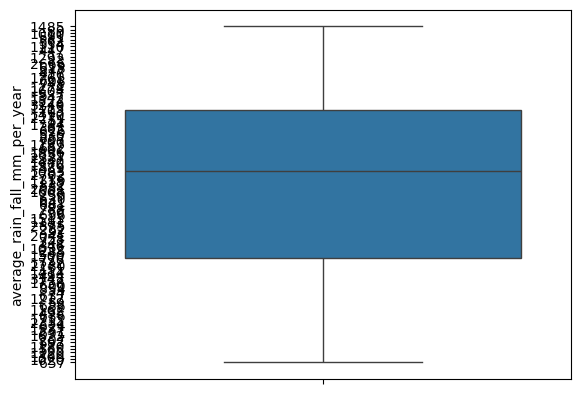

In [28]:
sns.boxplot(master_df['average_rain_fall_mm_per_year'])
plt.show()

No outliers were seen, so the '..' would be replaced using the mean

In [29]:
# Step 1: Replace '..' with NaN
master_df['average_rain_fall_mm_per_year'] = master_df['average_rain_fall_mm_per_year'].replace('..', np.nan)

# Step 2: Convert column to numeric
master_df['average_rain_fall_mm_per_year'] = pd.to_numeric(
    master_df['average_rain_fall_mm_per_year'],
    errors='coerce'
)

# Step 3: Replace NaN with mean
mean_value = master_df['average_rain_fall_mm_per_year'].mean()
master_df['average_rain_fall_mm_per_year'] = master_df['average_rain_fall_mm_per_year'].fillna(mean_value)

# Step 4: Verify
print(master_df['average_rain_fall_mm_per_year'].isnull().sum())  # should be 0
print(master_df['average_rain_fall_mm_per_year'].head())

0
0    1485.0
1    1485.0
2    1485.0
3    1485.0
4    1485.0
Name: average_rain_fall_mm_per_year, dtype: float64


# Univariate Analysis

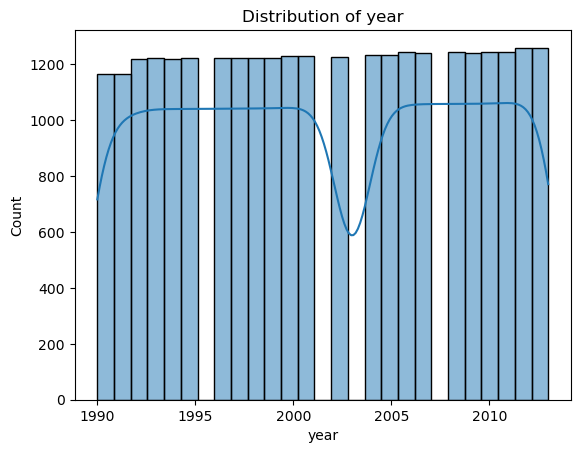

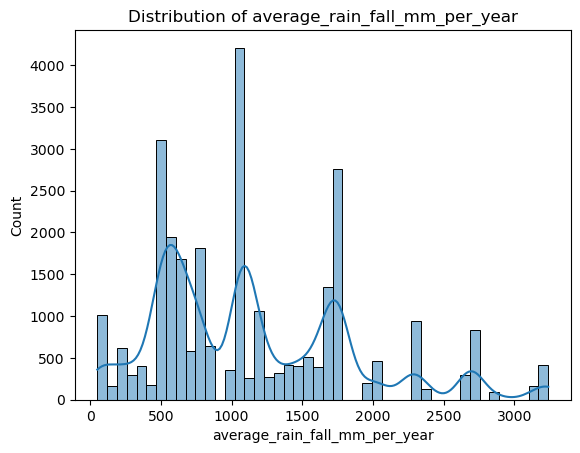

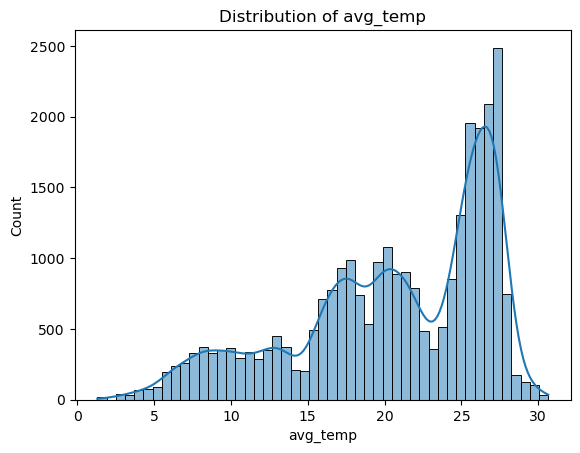

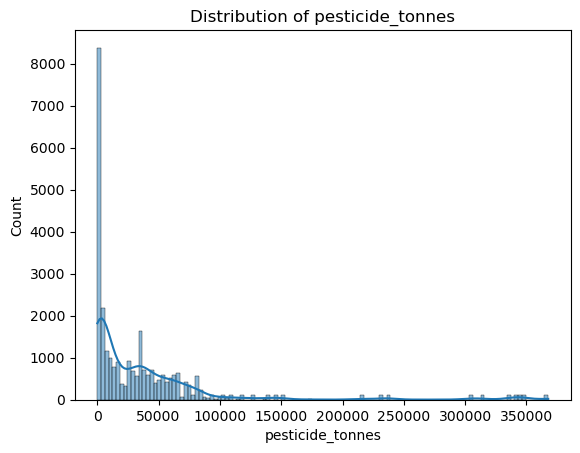

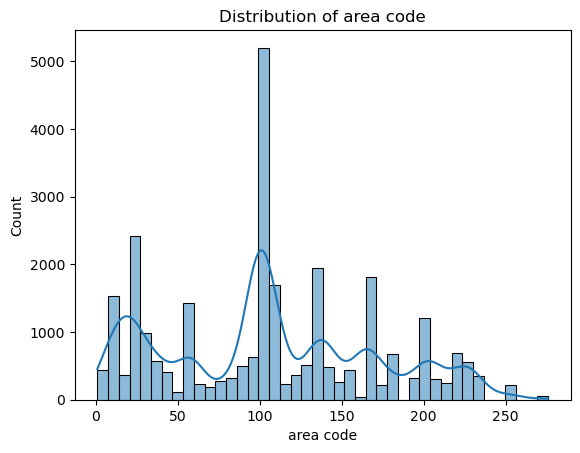

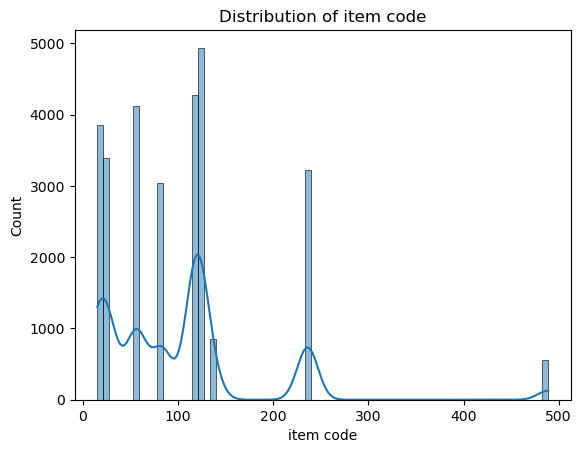

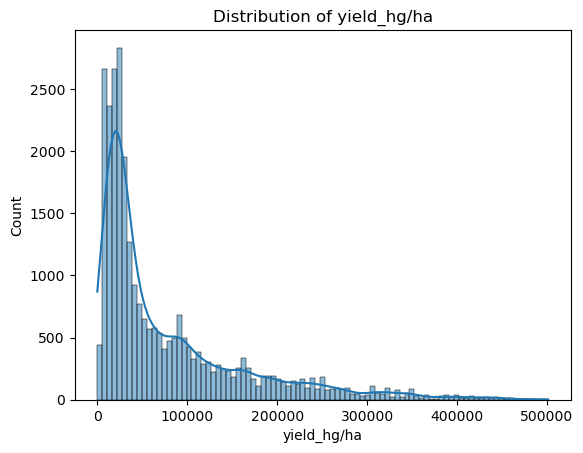

In [30]:
#Distribution of the numerical variables
num_cols = master_df.select_dtypes(include=['float64', 'int64']).columns
for col in num_cols:
    sns.histplot(master_df[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.show()

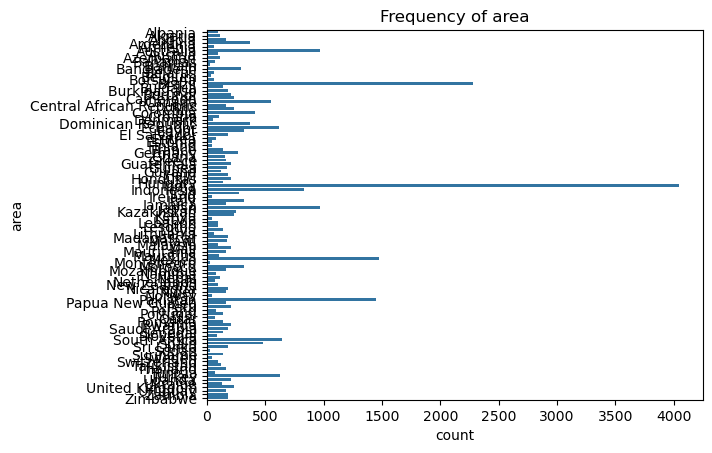

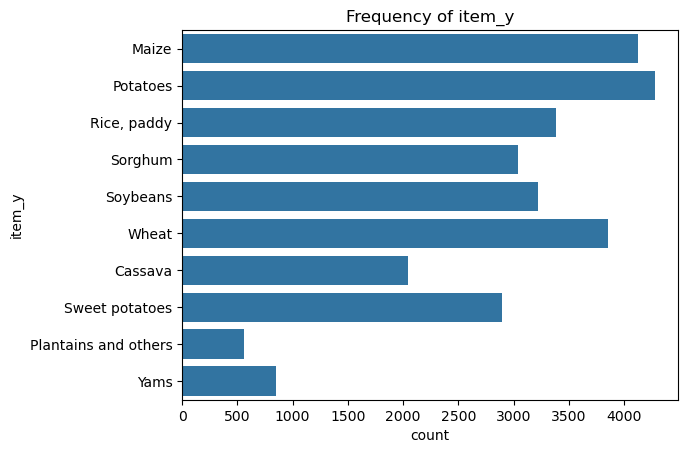

In [31]:
#Distribution of categorical variables
cat_cols = master_df.select_dtypes(include=['object']).columns
for col in cat_cols:
    sns.countplot(y=col, data=master_df)
    plt.title(f'Frequency of {col}')
    plt.show()

# Bivariate Analysis

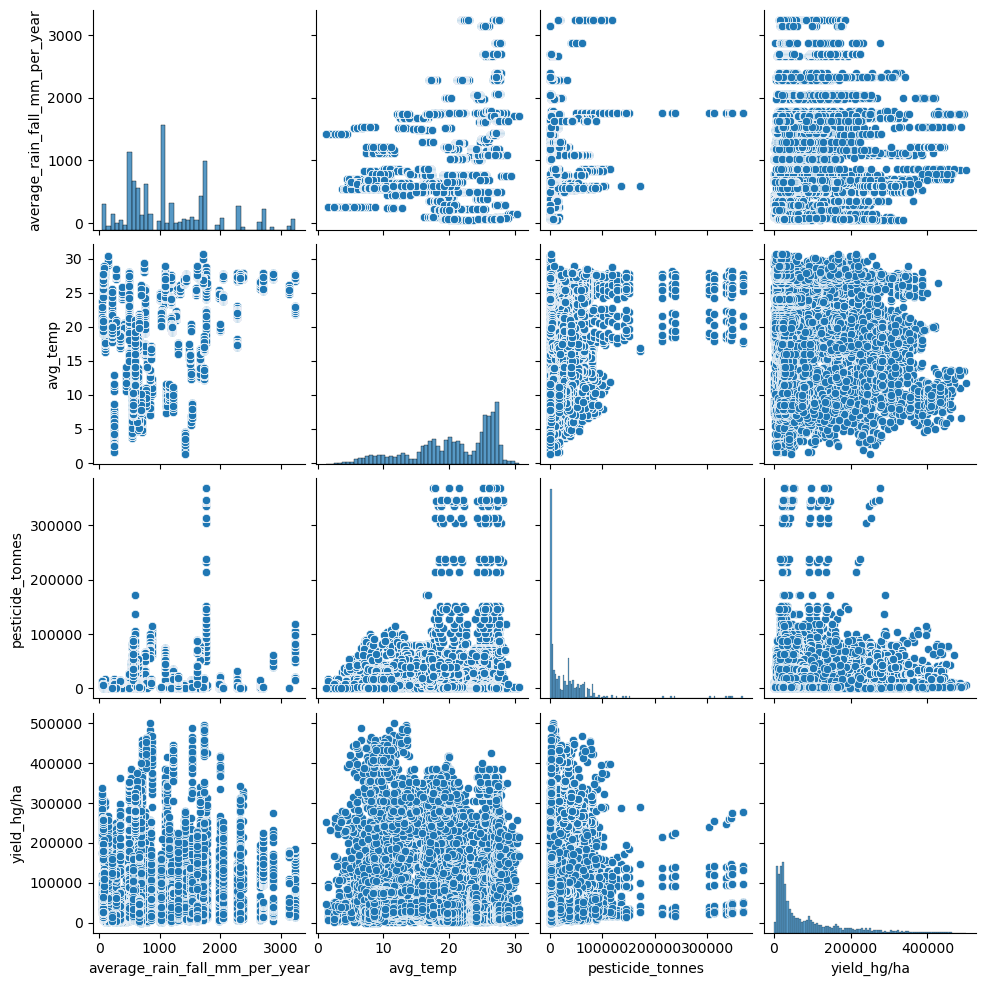

In [32]:
#Explore how independent variables relate to the target variable  'yield'
sns.pairplot(master_df, vars=['average_rain_fall_mm_per_year', 'avg_temp', 'pesticide_tonnes', 'yield_hg/ha'])
plt.show()

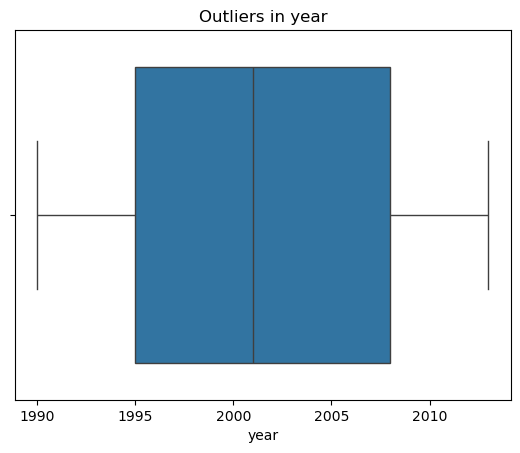

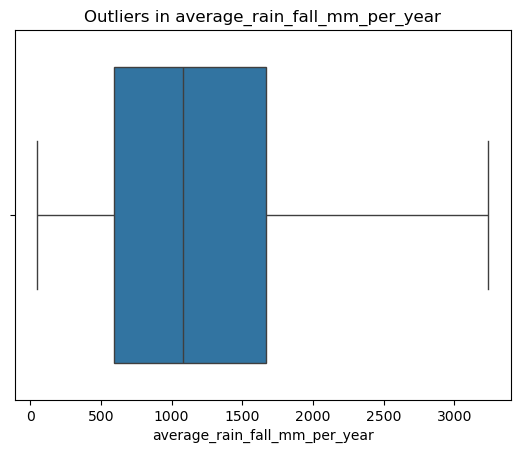

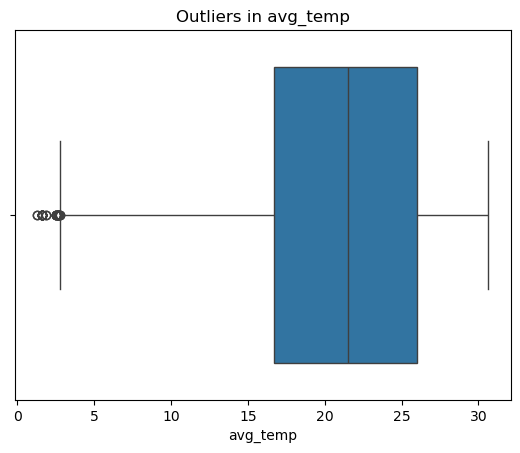

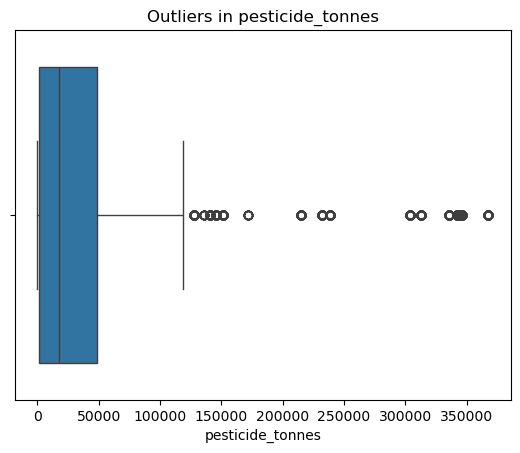

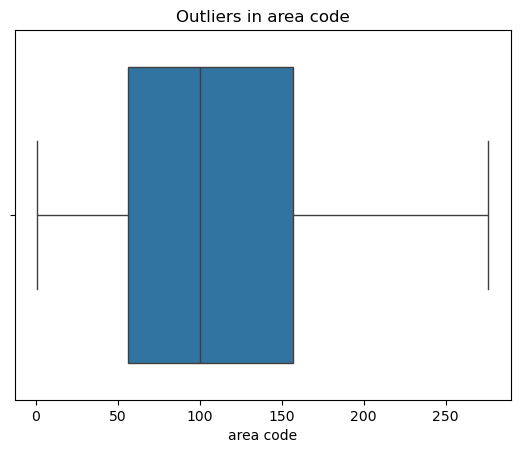

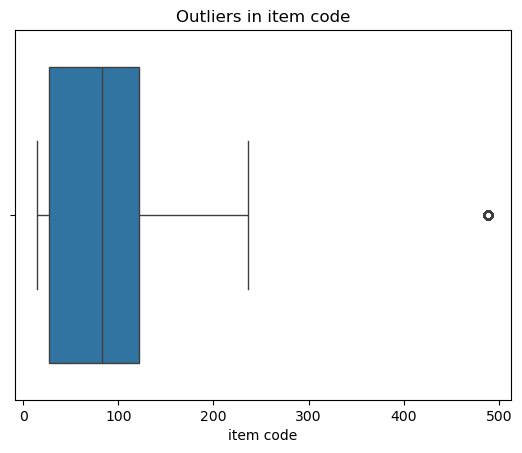

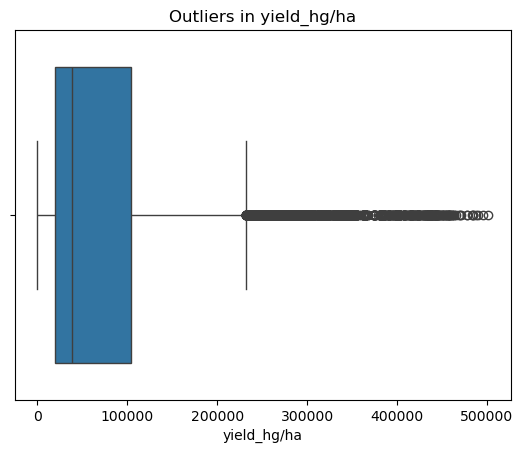

In [33]:
#Outliers Detection
for col in num_cols:
    sns.boxplot(x=master_df[col])
    plt.title(f'Outliers in {col}')
    plt.show()


In [34]:
numeric_cols = ['average_rain_fall_mm_per_year', 'pesticide_tonnes', 'avg_temp', 'yield_hg/ha']
def detect_outliers(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower) | (df[col] > upper)]
    return outliers

for col in numeric_cols:
    outliers = detect_outliers(master_df, col)
    print(f"{col}: {len(outliers)} outliers")

average_rain_fall_mm_per_year: 0 outliers
pesticide_tonnes: 1418 outliers
avg_temp: 34 outliers
yield_hg/ha: 2059 outliers


# Check the distribution of columns with outliers

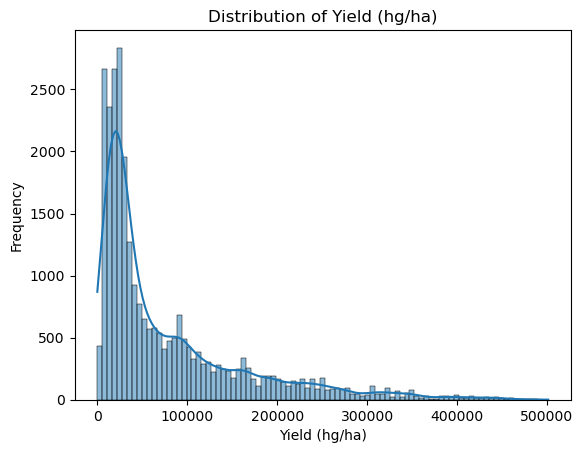

In [35]:
sns.histplot(master_df['yield_hg/ha'], kde=True)
plt.title("Distribution of Yield (hg/ha)")
plt.xlabel("Yield (hg/ha)")
plt.ylabel("Frequency")
plt.show()

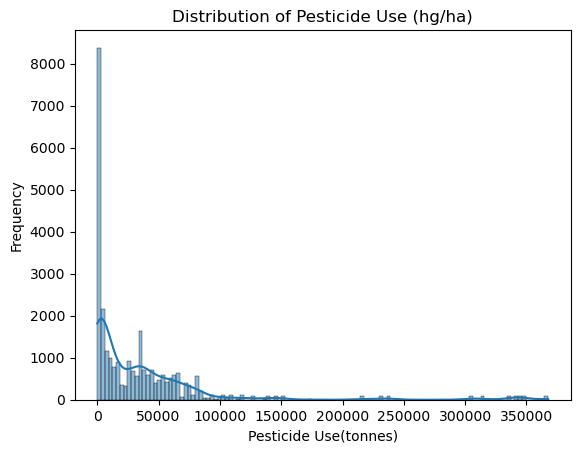

In [36]:
sns.histplot(master_df['pesticide_tonnes'],kde=True)
plt.title("Distribution of Pesticide Use (hg/ha)")
plt.xlabel("Pesticide Use(tonnes)")
plt.ylabel("Frequency")
plt.show()

Interpretation of Yield and Pesticide Use Distribution

Heavily Right-Skewed Distribution:
Most yield values are concentrated near the lower range (0–50,000 hg/ha) and 0 tonnes.
A few extreme values stretch far out toward 500,000 hg/ha and 350000 tonnes — clear outliers.

# Trend Analysis Over Time - how the key variables(temperature,rainfall,pesticide use, yield) changes by year

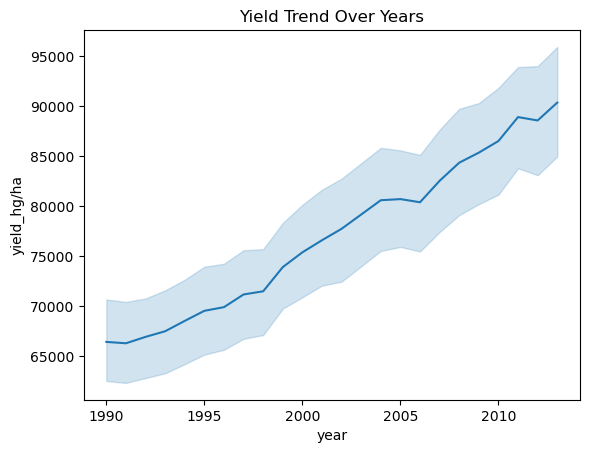

In [37]:
sns.lineplot(x='year', y='yield_hg/ha', data=master_df)
plt.title('Yield Trend Over Years')
plt.show()

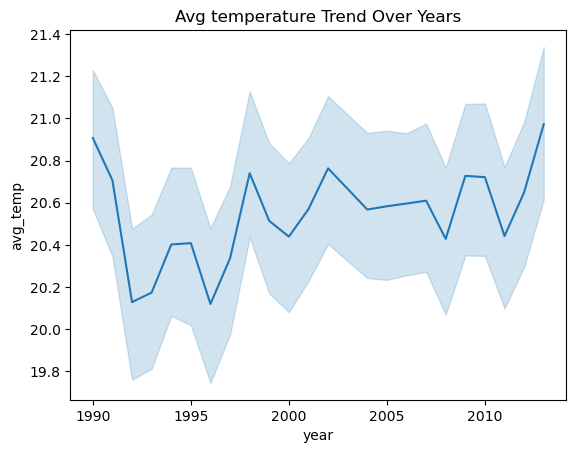

In [38]:
sns.lineplot(x='year', y='avg_temp', data=master_df)
plt.title('Avg temperature Trend Over Years')
plt.show()

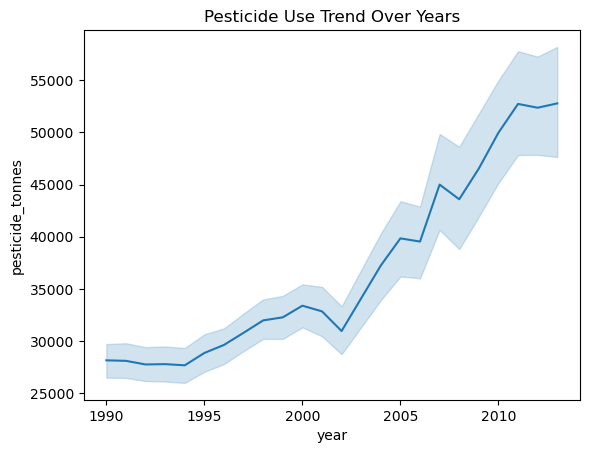

In [39]:
sns.lineplot(x='year', y='pesticide_tonnes', data=master_df)
plt.title('Pesticide Use Trend Over Years')
plt.show()

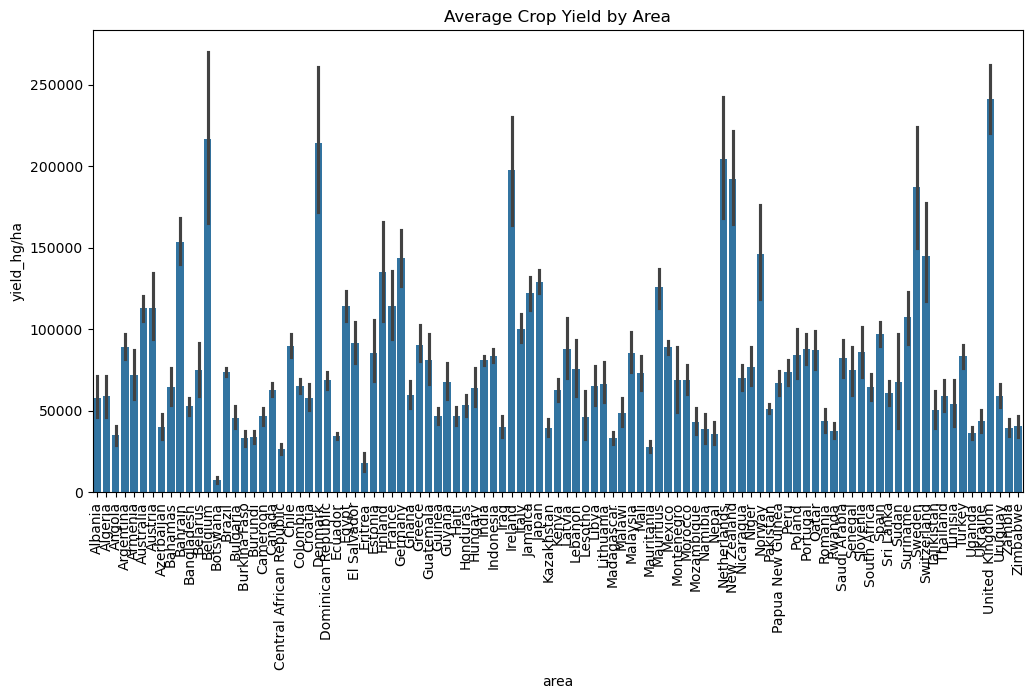

In [40]:
#Categorical Comparison
plt.figure(figsize=(12,6))
sns.barplot(x='area', y='yield_hg/ha', data=master_df)
plt.xticks(rotation=90)
plt.title('Average Crop Yield by Area')
plt.show()